# Vapor - Liquid Equilibria (Water + Furfuryl Alcohol)

In [1]:
import numpy as np
from epcsaftpy import component, pcsaft
from sgtpy.equilibrium import bubbleTy, lle, lle_init          # sgtpy module
import matplotlib.pyplot as plt

**Parameters Water from:**<br />
L. Cameretti, G. Sadowski. Chem. Eng. Process. 47, 1018-1025 (2008). https://doi.org/10.1016/j.cep.2007.02.034 <br /><br />

**Parameters Furfuryl Alcohol:**<br />
This work

In [2]:
Water = component('Water', ms = 1.2046817736, sigma = [2.7927, 10.11, -0.01775, -1.417, -0.01146], eps = 353.9449,
                 kappaAB = 0.045090, eAB = 2425.6714, sites = [0, 1, 1], Mw = 18.01528)
FA = component('Furfuryl Alcohol', ms = 4.361081, sigma = 3.004829 , eps = 218.33885, 
               kappaAB = 0.14622, eAB = 1834.334, sites = [0, 1, 2], Mw = 98.1014)
mix = Water + FA
mix.set_kijsaft(i = 0, j = 1, kij0 = -0.01)
saft = pcsaft(mix)
saft_Water = pcsaft(Water)
saft_FA = pcsaft(FA)

**Calculation**<br />
VLE calculation using sgtpy module (https://github.com/gustavochm/sgtpy)

In [3]:
P = 7330.                        # Pressure [Pa]

n = 100
x10 = 1.       
x1f = 0.
x1 = np.linspace(x10, x1f, n)    # mol fracction vector 
x = np.array([x1, 1 - x1]).T
T = []
xW = []
yW = []

# VLE
T0 = 300.
y0 = x[0]
T0, vL0, vV0 = saft_Water.tsat(P, T0 = T0)
v0 = np.array([vL0, vV0])
Xass0 = [None, None]
for i in range(n):
    out = bubbleTy(y0, T0, x[i], P, saft, good_initial = True,
                     v0 = v0, Xass0 = Xass0, full_output = True)
    Xass0 = np.array([out.Xassl, out.Xassv])
    v0 = np.array([out.v1, out.v2])
    y0 = out.Y
    T0 = out.T
    T.append(T0), xW.append(x1[i]), yW.append(y0[0])
    
# LLE
n = 100
T0 = 250.
Tf = 350.
T2 = np.linspace(T0, Tf, n)
zW = 0.9
z = np.array([zW, 1 - zW])
x0, w0 = lle_init(z, T0, P, saft)


v0 = [None, None]
Xass0 = [None, None]
Tll = []
xWll = []
wWll = []
for i in range(n):
    z = (x0 +  w0)/2
    out = lle(x0, w0, z, T2[i], P, saft,
            v0 = v0, Xass0 = Xass0, full_output = True)
    if out.error_outer>1e-5 or out.error_inner>1e-5:
        break
    if abs((out.v[0] - out.v[1])/out.v[0])< 1e-2:
        break
    Xass0 = out.Xass
    v0 = out.v
    x0 = out.X[0]
    w0 = out.X[1]
    Tll.append(T2[i]), xWll.append(x0[0]), wWll.append(w0[0])
    

**Plotting**<br />
Experimental information were retrieved from the ASPEN data base.

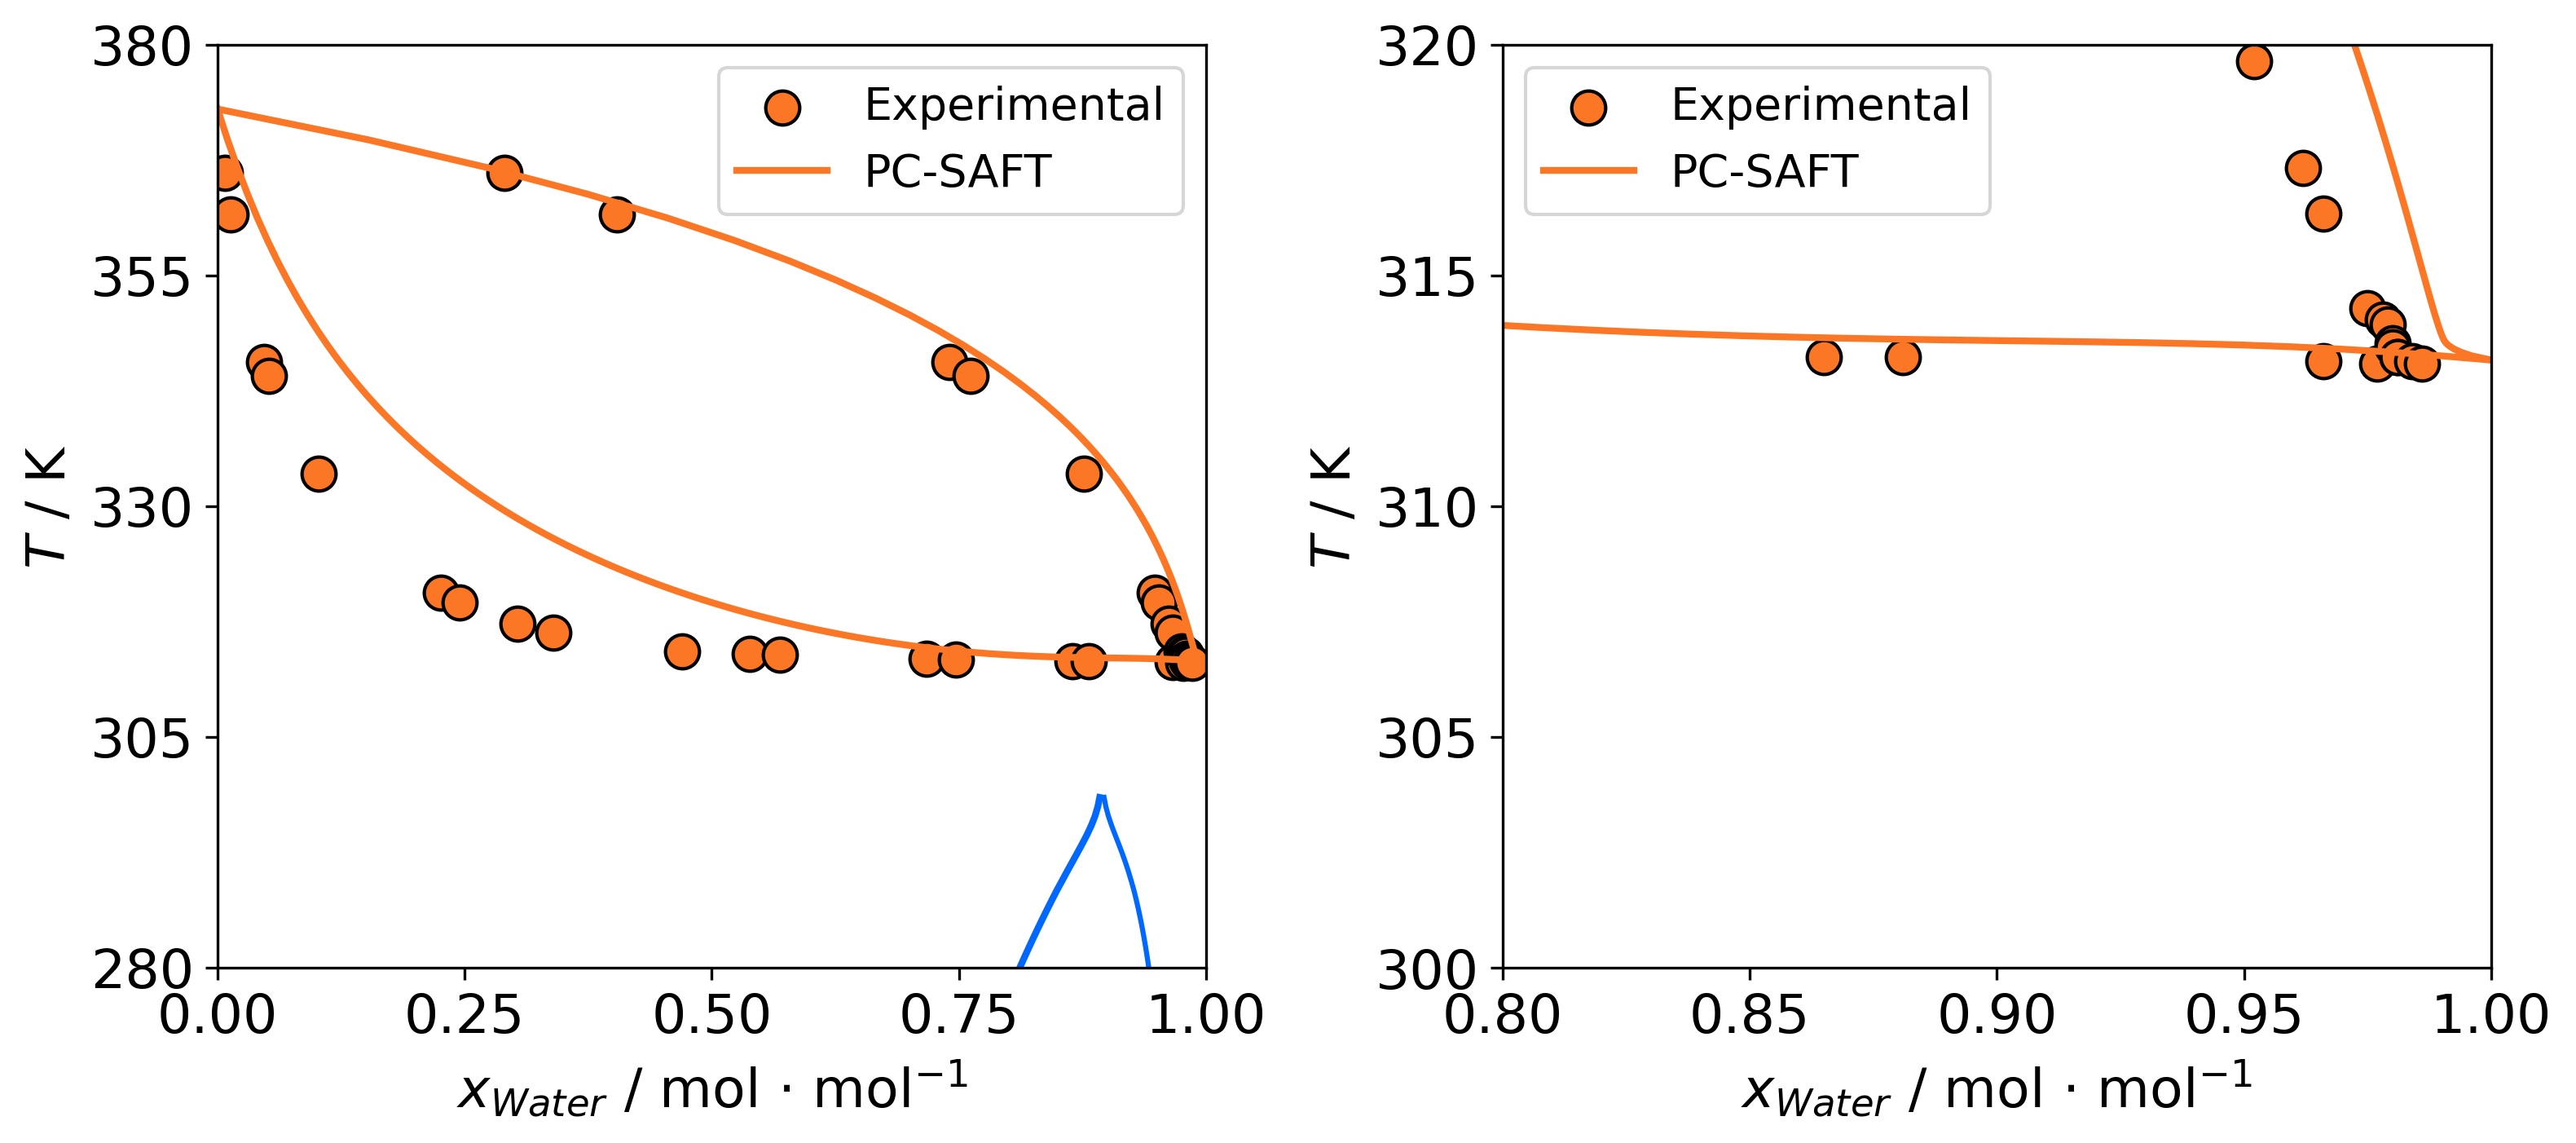

In [4]:
Texp = np.array([366.12577, 361.62667, 345.68129, 344.131755,
                 333.53429, 320.637805, 319.638105, 317.338795,
                 316.339095, 314.28971, 314.039785, 313.939815,
                 313.539935, 313.439965, 313.240025, 313.240025,
                 313.140055, 313.09007])
xWexp = np.array([0.0075, 0.013, 0.047, 0.052, 0.102, 0.226,
                  0.245, 0.303, 0.34, 0.47, 0.538, 0.569,
                  0.717, 0.747, 0.865, 0.881, 0.966, 0.977])
yWexp = np.array([0.29, 0.404, 0.74, 0.762, 0.876, 0.948, 
                  0.952, 0.962, 0.966, 0.975, 0.978, 0.979,
                  0.98, 0.98, 0.981, 0.981, 0.984, 0.986])

font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

colorLLE = "#0068FF"
colorVLE = "#FC7725"

fig, axs = plt.subplots(1,2, figsize=(12, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax = axs[0]
ax.scatter(xWexp, Texp, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(yWexp, Texp, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(xW, T, color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(yW, T, color = colorVLE , 
        linewidth = 2.0)

ax.plot(xWll, Tll, color = colorLLE)
ax.plot(wWll, Tll, color = colorLLE, 
        linewidth = 2.0)

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_{Water}$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 280, 380])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))


ax = axs[1]
ax.scatter(xWexp, Texp, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(yWexp, Texp, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(xW, T, color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(yW, T, color = colorVLE , 
        linewidth = 2.0)
ax.plot(xWll, Tll, color = colorLLE)
ax.plot(wWll, Tll, color = colorLLE, 
        linewidth = 2.0)

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_{Water}$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0.8, 1., 300, 320])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))

plt.show()

## At 1.013 bar

In [5]:
P = 1.013e5                        # Pressure [Pa]

n = 100
x10 = 1.       
x1f = 0.
x1 = np.linspace(x10, x1f, n)    # mol fracction vector 
x = np.array([x1, 1 - x1]).T
T = []
xW = []
yW = []

# VLE
T0 = 400.
y0 = x[0]
T0, vL0, vV0 = saft_Water.tsat(P, T0 = T0)
v0 = np.array([vL0, vV0])
Xass0 = [None, None]
for i in range(n):
    out = bubbleTy(y0, T0, x[i], P, saft, good_initial = True,
                     v0 = v0, Xass0 = Xass0, full_output = True)
    Xass0 = np.array([out.Xassl, out.Xassv])
    v0 = np.array([out.v1, out.v2])
    y0 = out.Y
    T0 = out.T
    T.append(T0), xW.append(x1[i]), yW.append(y0[0])
    
# LLE
n = 100
T0 = 250.
Tf = 350.
T2 = np.linspace(T0, Tf, n)
zW = 0.9
z = np.array([zW, 1 - zW])
x0, w0 = lle_init(z, T0, P, saft)


v0 = [None, None]
Xass0 = [None, None]
Tll = []
xWll = []
wWll = []
for i in range(n):
    z = (x0 +  w0)/2
    out = lle(x0, w0, z, T2[i], P, saft,
            v0 = v0, Xass0 = Xass0, full_output = True)
    if out.error_outer>1e-1 or out.error_inner>1e-1:
        break
    if abs((out.v[0] - out.v[1])/out.v[0])< 1e-2:
        break
    Xass0 = out.Xass
    v0 = out.v
    x0 = out.X[0]
    w0 = out.X[1]
    Tll.append(T2[i]), xWll.append(x0[0]), wWll.append(w0[0])
    

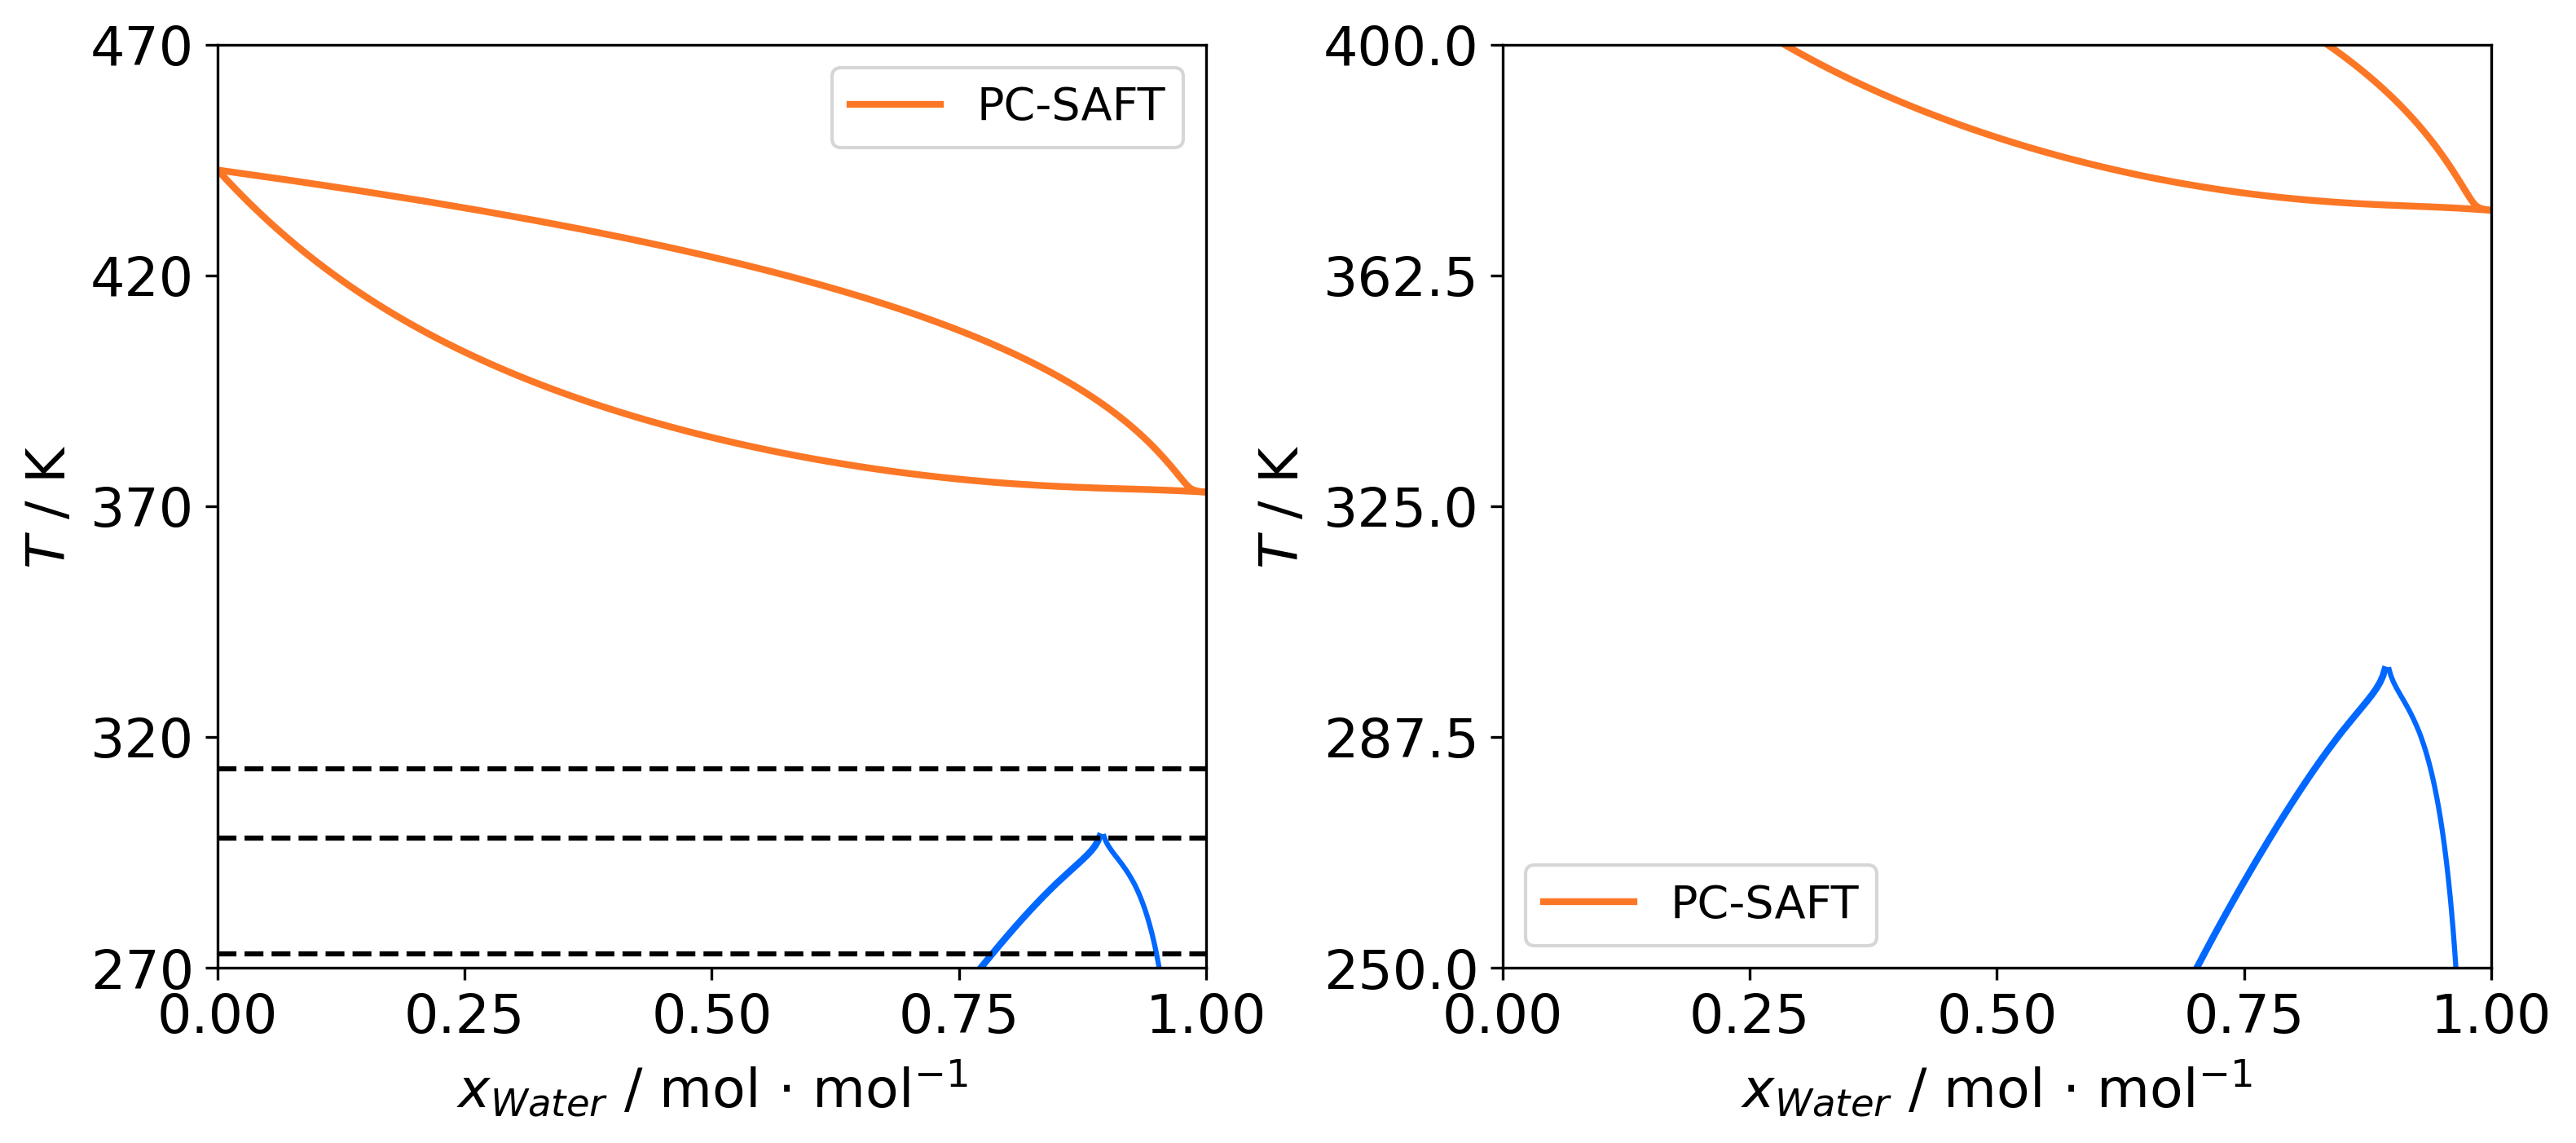

In [6]:
Texp = np.array([366.12577, 361.62667, 345.68129, 344.131755,
                 333.53429, 320.637805, 319.638105, 317.338795,
                 316.339095, 314.28971, 314.039785, 313.939815,
                 313.539935, 313.439965, 313.240025, 313.240025,
                 313.140055, 313.09007])
xWexp = np.array([0.0075, 0.013, 0.047, 0.052, 0.102, 0.226,
                  0.245, 0.303, 0.34, 0.47, 0.538, 0.569,
                  0.717, 0.747, 0.865, 0.881, 0.966, 0.977])
yWexp = np.array([0.29, 0.404, 0.74, 0.762, 0.876, 0.948, 
                  0.952, 0.962, 0.966, 0.975, 0.978, 0.979,
                  0.98, 0.98, 0.981, 0.981, 0.984, 0.986])

font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

colorLLE = "#0068FF"
colorVLE = "#FC7725"

fig, axs = plt.subplots(1,2, figsize=(12, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax = axs[0]
ax.plot(xW, T, color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(yW, T, color = colorVLE , 
        linewidth = 2.0)

ax.plot(xWll, Tll, color = colorLLE)
ax.plot(wWll, Tll, color = colorLLE, 
        linewidth = 2.0)
ax.plot([0, 1], [273.15, 273.15], "--k")
ax.plot([0, 1], [298.15, 298.15], "--k")
ax.plot([0, 1], [313.15, 313.15], "--k")

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_{Water}$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 270, 470])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))


ax = axs[1]
ax.plot(xW, T, color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(yW, T, color = colorVLE , 
        linewidth = 2.0)
ax.plot(xWll, Tll, color = colorLLE)
ax.plot(wWll, Tll, color = colorLLE, 
        linewidth = 2.0)

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_{Water}$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 250, 400])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))

plt.show()
